In [2]:
#importing yfinance api and pandas
import pandas as pd
import yfinance as yf
import datetime as datetime

#fetching data from S&P 500 index using yfinance api
sp500_df = yf.download('^GSPC', start = datetime.datetime(2014, 7, 18), end = datetime.datetime(2024, 7, 18))

[*********************100%%**********************]  1 of 1 completed


In [3]:
sp500_df.shape

(2516, 6)

In [4]:
#performing some preliminary data checks
sp500_df.dtypes #checking the data types of each feature

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [5]:
sp500_df.isna().sum() #calculate 'NaN' counts for each column

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
sp500_df = sp500_df.drop(['Open', 'High', 'Low', 'Volume'], axis=1)
sp500_df.head()

,Close,Adj Close
Date,,
2014-07-18,1978.219971,1978.219971
2014-07-21,1973.630005,1973.630005
2014-07-22,1983.530029,1983.530029
2014-07-23,1987.010010,1987.010010
2014-07-24,1987.979980,1987.979980


In [7]:
#performing augmented Dickey-Fuller test
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

result = adfuller(sp500_df['Adj Close'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
#Null hypothesis is true. The values are not stationary

ADF Statistic: 0.409816
p-value: 0.981858
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


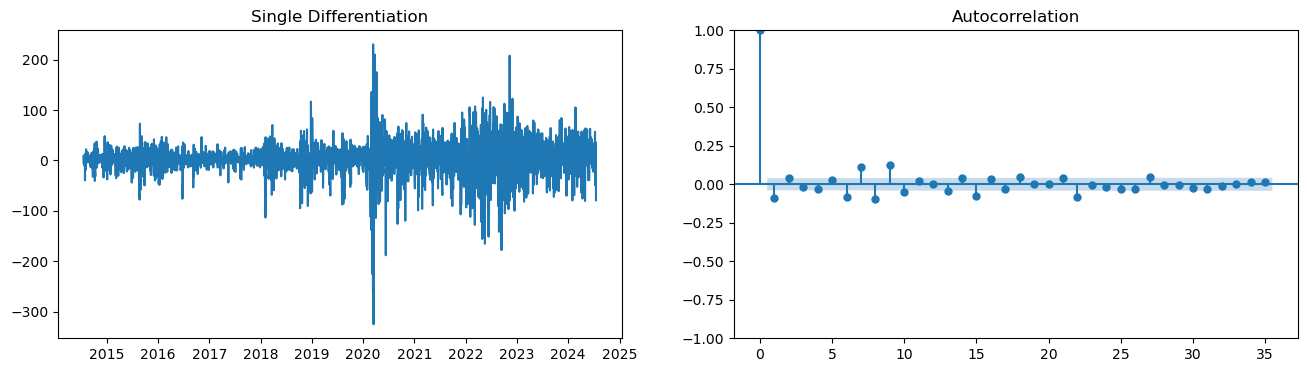

In [26]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

diff1 = sp500_df['Adj Close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff1)
ax1.set_title("Single Differentiation")
plot_acf(diff1, ax=ax2);

In [9]:
result = adfuller(diff1)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -15.549158
p-value: 0.000000


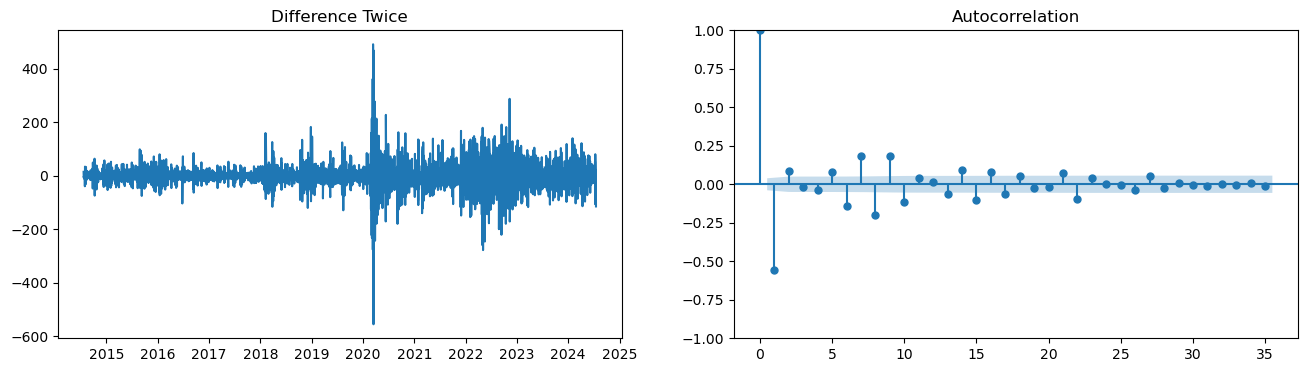

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
diff2 = sp500_df['Adj Close'].diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff2)
ax1.set_title("Difference Twice")
plot_acf(diff2, ax=ax2);

In [11]:
result = adfuller(diff2)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -16.057002
p-value: 0.000000


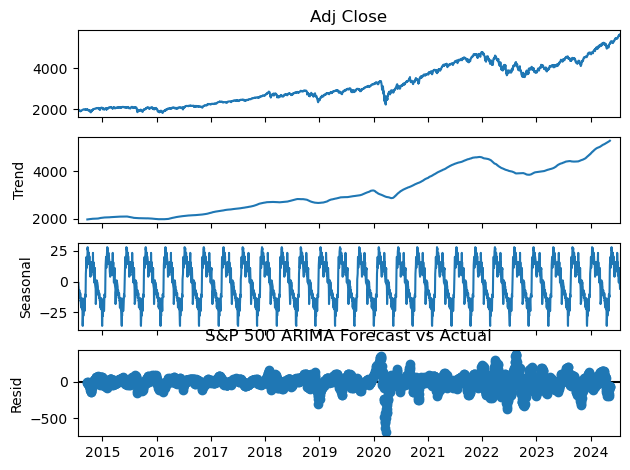

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(sp500_df['Adj Close'], model='additive', period=90)
decomposition.plot()
plt.title('S&P 500 ARIMA Forecast vs Actual')
plt.show()

In [17]:
from pmdarima.arima.utils import ndiffs
ndiffs(sp500_df['Adj Close'], test="adf")

1

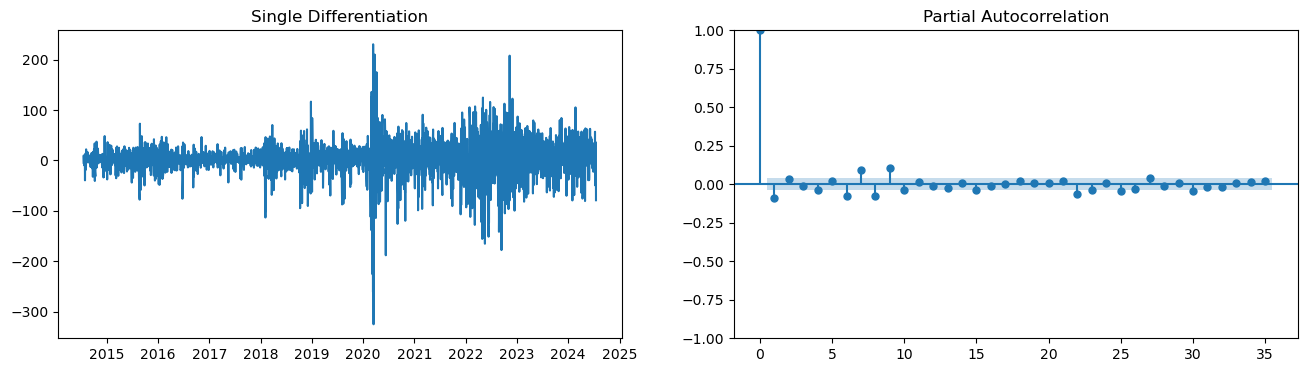

In [27]:
from statsmodels.graphics.tsaplots import plot_pacf
diff1 = sp500_df['Adj Close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff1)
ax1.set_title("Single Differentiation")
ax2.set_ylim(0, 1)
plot_pacf(diff1, ax=ax2);

In [19]:
#creating test and train datasets
train, test = sp500_df['Adj Close'][:2012], sp500_df['Adj Close'][2012:]

In [20]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(7,1,7))
results = model.fit()
print(results.summary())

/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 2012
Model:                 ARIMA(7, 1, 7)   Log Likelihood               -9882.195
Date:                Fri, 19 Jul 2024   AIC                          19794.391
Time:                        16:04:51   BIC                          19878.486
Sample:                             0   HQIC                         19825.260
                               - 2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7561      0.342     -2.208      0.027      -1.427      -0.085
ar.L2          0.4819      0.521      0.925      0.355      -0.539       1.503
ar.L3          0.3702      0.258      1.435      0.1

/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(array([4.38541381e-04, 4.03814246e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.22609838e-06]),
 array([-254.46613672,  -31.19752597,  192.07108477,  415.33969551,
         638.60830625,  861.87691699, 1085.14552774, 1308.41413848,
        1531.68274922, 1754.95135996, 1978.2199707 ]),
 <BarContainer object of 10 artists>)

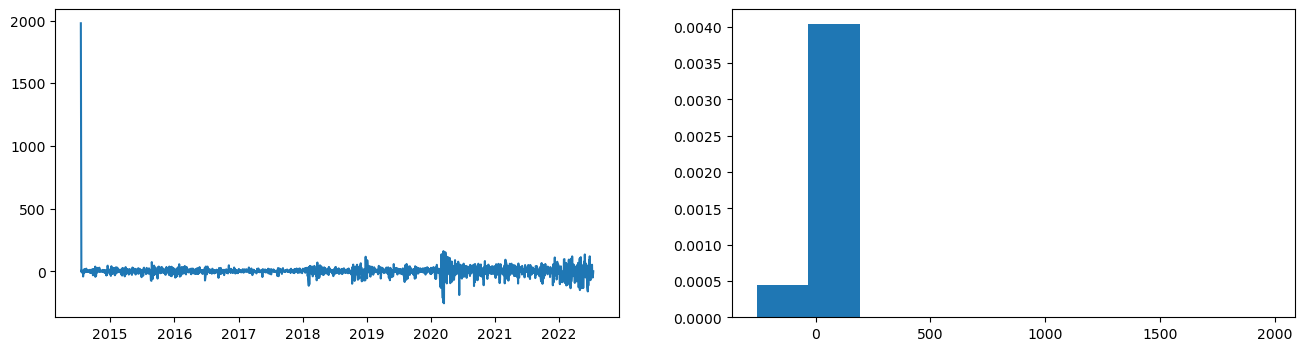

In [21]:
residuals = pd.DataFrame(results.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


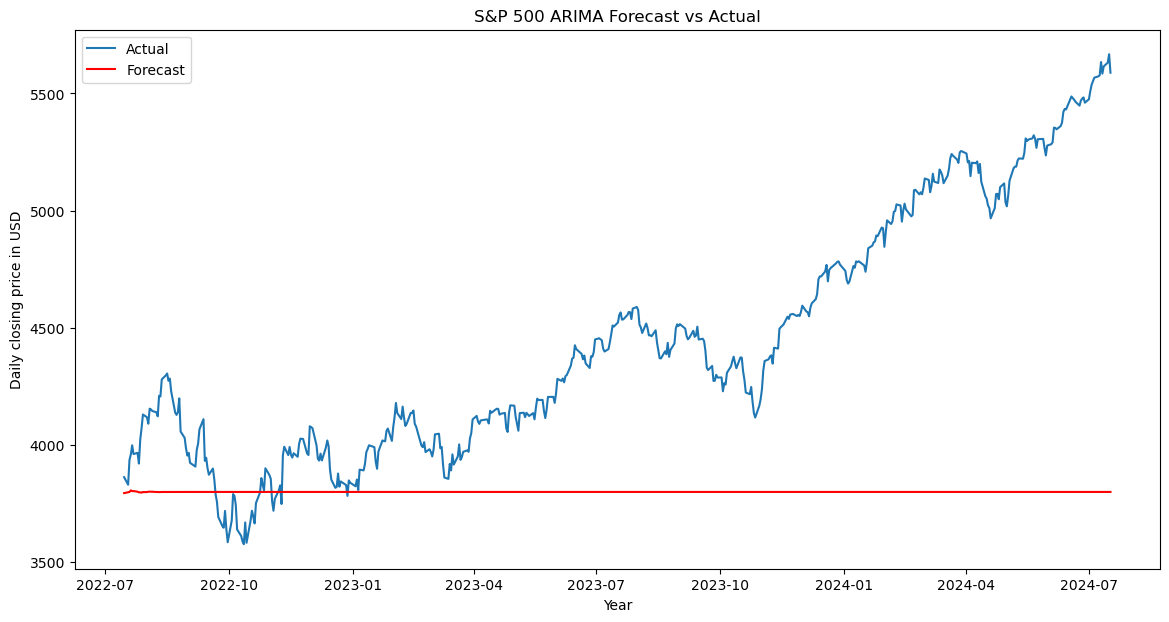

In [22]:
import statsmodels.api as sm
forecast = results.forecast(steps=len(test), alpha=0.05)  # 95% conf

#plot the forecast vs actual values
plt.figure(figsize=(14, 7))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('S&P 500 ARIMA Forecast vs Actual')
plt.xlabel('Year')
plt.ylabel('Daily closing price in USD')
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 657.4906910829009
Root Mean Squared Error: 825.6103452884213


In [23]:
from pmdarima.arima import auto_arima

model1 = auto_arima(train, seasonal=True, suppress_warnings=True, with_intercept=False)
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2012
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -9941.876
Date:                Fri, 19 Jul 2024   AIC                          19889.752
Time:                        16:04:59   BIC                          19906.571
Sample:                             0   HQIC                         19895.926
                               - 2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1153      0.010    -11.733      0.000      -0.135      -0.096
ma.L2          0.0855      0.009      9.455      0.000       0.068       0.103
sigma2      1152.3959     15.451     74.582      0.0

In [22]:
model2 = auto_arima(train, start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 0, seasonal=True, d=1, D=1, trace=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.38 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=21142.335, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=20573.387, Time=0.43 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.28 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=21121.236, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=20291.252, Time=1.70 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.28 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.86 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=20319.222, Time=0.81 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=20278.488, Time=1.54 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=20550.871, Time=0.61 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=6.75 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.53 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=20279.210, Time=1.42 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AI

In [23]:
print(model2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 2012
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood              -10134.244
Date:                            Fri, 19 Jul 2024   AIC                          20278.488
Time:                                    14:27:43   BIC                          20306.490
Sample:                                         0   HQIC                         20288.770
                                           - 2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1116      0.011    -10.098      0.000      -0.133      -0.090
ar.L2          0.0862      0.011   

/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be g

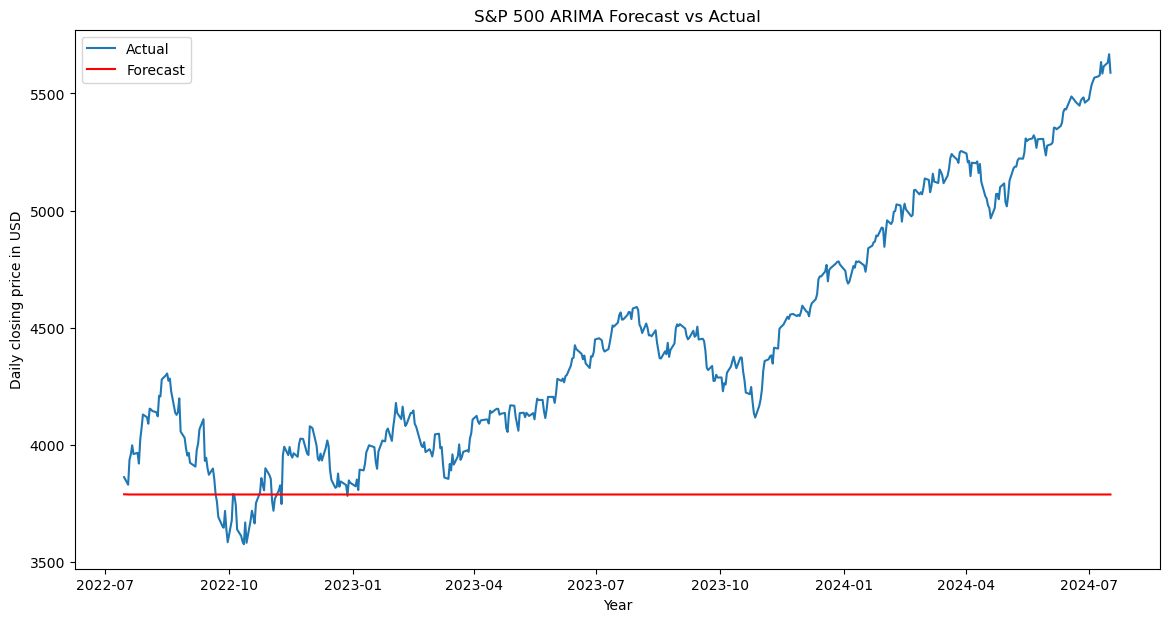

In [24]:
model = ARIMA(train, order=(0,1,2))
results = model.fit()
forecast = results.forecast(steps=len(test), alpha=0.05)  # 95% conf

#plot the forecast vs actual values
plt.figure(figsize=(14, 7))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('S&P 500 ARIMA Forecast vs Actual')
plt.xlabel('Year')
plt.ylabel('Daily closing price in USD')
plt.legend()
plt.show()

/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.88607D+00    |proj g|=  2.47971D-02

At iterate    5    f=  4.88196D+00    |proj g|=  4.28873D-02

At iterate   10    f=  4.85738D+00    |proj g|=  4.77884D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   6.644D-06   4.857D+00
  F =   4.8573670830803302     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


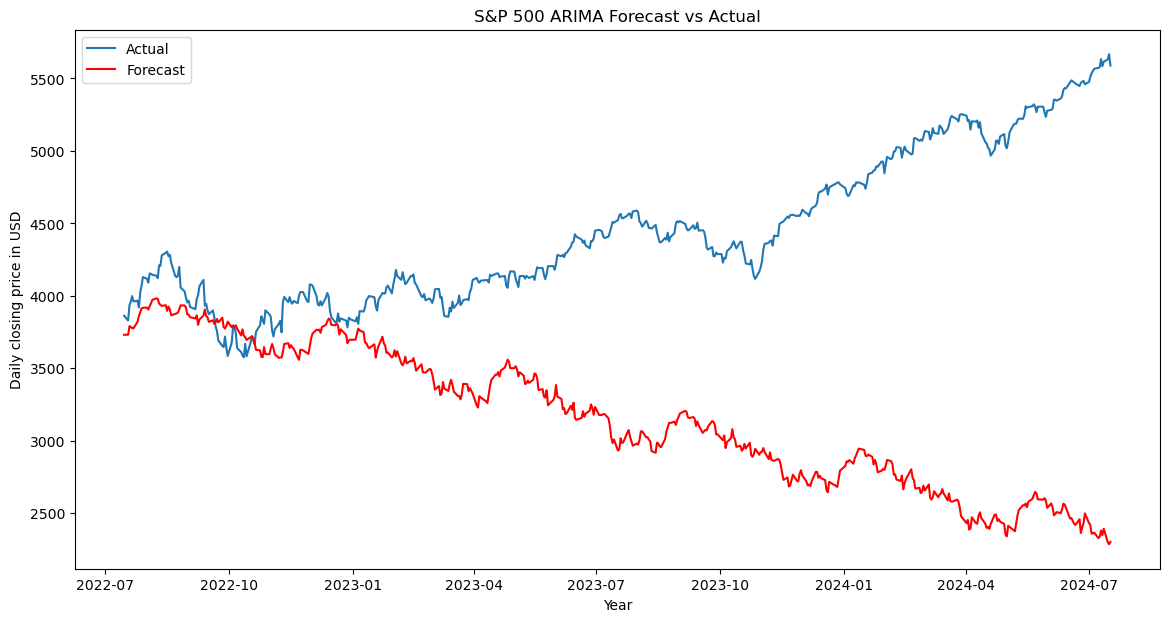

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


model3 = SARIMAX(train, order=(2, 1, 0), seasonal_order=(2, 1, 0, 90))
results3 = model3.fit()
forecast3 = results3.forecast(steps=len(test), alpha=0.05)  # 95% conf

#plot the forecast vs actual values
plt.figure(figsize=(14, 7))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast3, label='Forecast', color='red')
plt.title('S&P 500 SARIMA Forecast vs Actual')
plt.xlabel('Year')
plt.ylabel('Daily closing price in USD')
plt.legend()
plt.show()

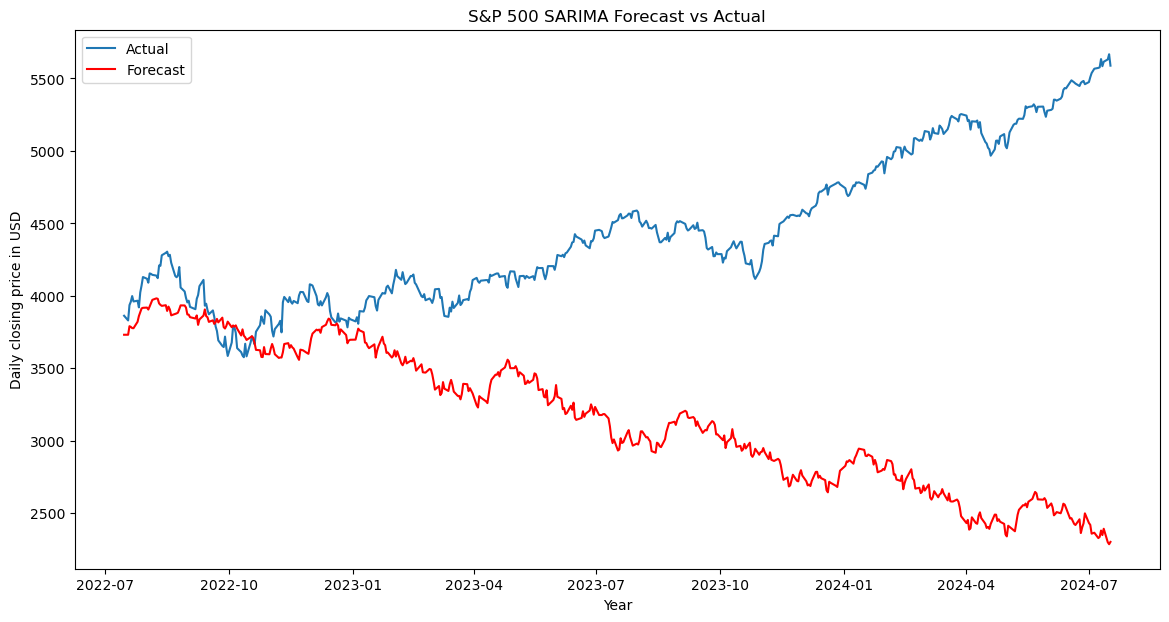

In [28]:
#plot the forecast vs actual values
plt.figure(figsize=(14, 7))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast3, label='Forecast', color='red')
plt.title('S&P 500 SARIMA Forecast vs Actual')
plt.xlabel('Year')
plt.ylabel('Daily closing price in USD')
plt.legend()
plt.show()

In [32]:
mae = mean_absolute_error(test, forecast3)
rmse = np.sqrt(mean_squared_error(test, forecast3))
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 1280.2888052891474
Root Mean Squared Error: 1597.5372384527573
